In [73]:
from dataget import data
import tfinterface as ti
import sonnet as snt
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cytoolz as cz

sess = tf.InteractiveSession()

In [64]:
dataset = data("mnist").get()

traning_set = dataset.complete_set

traning_set.df = traning_set.df.sample(frac=1)

In [5]:
class Discriminator(snt.AbstractModule):
    
    def _build(self, inputs):
        
        net = inputs["image"]; print(net)
        training = inputs["mode"] == tf.estimator.ModeKeys.TRAIN
        
        net = ti.layers.conv2d_batch_norm(net, 16, [5, 5], strides = 2, activation = tf.nn.elu, padding = "same", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_batch_norm(net, 32, [3, 3], strides = 2, activation = tf.nn.elu, padding = "valid", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_batch_norm(net, 64, [3, 3], strides = 2, activation = tf.nn.elu, padding = "valid", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_batch_norm(net, 128, [2, 2], strides = 2, activation = tf.nn.elu, padding = "same", batch_norm = dict(training = training)); print(net)

        
        net = tf.contrib.layers.flatten(net); print(net)
        
        net = ti.layers.dense_batch_norm(net, 64, activation = tf.nn.elu, batch_norm = dict(training = training)); print(net)
        net = logits = tf.layers.dense(net, 1, activation = None); print(net)
#         net = tf.nn.sigmoid(net); print(net)
        
        return logits
    
    
class Generator(snt.AbstractModule):
    
    def _build(self, inputs):
        
        
        training = inputs["mode"] == tf.estimator.ModeKeys.TRAIN
        net = inputs["embedding"]; print(net)
        
        net = ti.layers.conv2d_transpose_batch_norm(net, 512, [2, 2], strides = 1, activation = tf.nn.elu, 
                                                    padding = "valid", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_transpose_batch_norm(net, 256, [3, 3], strides = 2, activation = tf.nn.elu, 
                                                    padding = "valid", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_transpose_batch_norm(net, 128, [3, 3], strides = 2, activation = tf.nn.elu, 
                                                    padding = "same", batch_norm = dict(training = training)); print(net)
        net = ti.layers.conv2d_transpose_batch_norm(net, 1, [3, 3], strides = 2, activation = tf.nn.tanh, 
                                                    padding = "same", batch_norm = dict(training = training)); print(net)
        
        net = (net + 1.0) / 2.0
        
        
        return net

In [6]:
inputs = dict(
    image = tf.layers.Input(shape=(28, 28, 1)),
    embedding = tf.layers.Input(shape=(2, 2, 25)),
    mode = tf.estimator.ModeKeys.TRAIN,
)

D = Discriminator(name = "discriminator")
G = Generator(name = "generator")

print("Discriminator")

d = D(inputs)
print("")
print("Generator")
g = G(inputs)

Discriminator
Tensor("input_layer_3:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm/Elu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm_1/Elu:0", shape=(?, 6, 6, 32), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm_2/Elu:0", shape=(?, 2, 2, 64), dtype=float32)
Tensor("discriminator/Conv2dBatchNorm_3/Elu:0", shape=(?, 1, 1, 128), dtype=float32)
Tensor("discriminator/Flatten/flatten/Reshape:0", shape=(?, 128), dtype=float32)
Tensor("discriminator/DenseBatchNorm/Elu:0", shape=(?, 64), dtype=float32)
Tensor("discriminator/dense/BiasAdd:0", shape=(?, 1), dtype=float32)

Generator
Tensor("input_layer_4:0", shape=(?, 2, 2, 25), dtype=float32)
Tensor("generator/Conv2dTransposeBatchNorm/Elu:0", shape=(?, 3, 3, 512), dtype=float32)
Tensor("generator/Conv2dTransposeBatchNorm_1/Elu:0", shape=(?, 7, 7, 256), dtype=float32)
Tensor("generator/Conv2dTransposeBatchNorm_2/Elu:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator/

(28, 28)


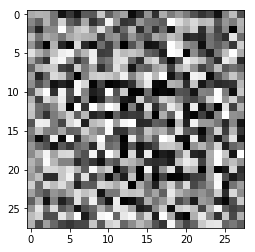

In [35]:
sample = np.random.uniform(size=(1, 2, 2, 25))
embedding = inputs["embedding"]

sess.run(tf.global_variables_initializer())

img = sess.run(g, feed_dict={embedding: sample})

img = np.squeeze(img * 255).astype(np.uint8)

print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

In [87]:
def input_fn(df, img_shape = [28, 28], embeddings_shape = [2, 2, 25], epochs = 10, batch_size = 64):
    
    def parse(filename):
        
        img = tf.read_file(filename)
        img = tf.image.decode_jpeg(img, channels = 1)
        img = tf.image.resize_images(img, img_shape)
    
        return img
    
    def embeddings():
        for i in range(len(df)):
            yield np.random.normal(size=embeddings_shape)
    
    
    ds = tf.data.Dataset.from_tensor_slices(df.filename.as_matrix())
    ds = ds.map(parse)
    
    
    ds1 = tf.data.Dataset.from_generator(
        embeddings,
        
    )
    
    ds = ds.shuffle(buffer_size = 1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat(epochs)
    
    it = ds.make_one_shot_iterator()
    img = it.get_next()
    
    
    return img



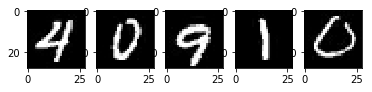

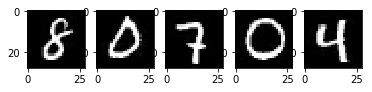

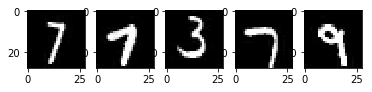

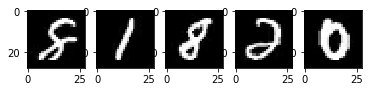

In [90]:
image = input_fn(traning_set.df, batch_size=20)

images = sess.run(image)

for images in cz.partition(5, images):
    
    fig, axes = plt.subplots(1, 5, subplot_kw=dict())
    
    for i, img in enumerate(images):
        
        
        img = np.squeeze(img).astype(np.uint8)
    
        axes[i].imshow(img, cmap="gray")
    
    fig.show()
    
plt.show()

In [58]:
img

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 254,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 252,   0, 252,   0,
        254, 254,   0, 251, 254,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 252,   0, 250,
        252, 252, 253,   0,   0, 247,   0, 255,   0,   0, 254,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 250,   0,
        254, 249, 238, 102,   1,  47,  82, 252,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 254, 255, 252,
        250, 221,  30,   1,   1,  40,  67, 255,   0,   0, 254,   0,   0,
          0,   0],
       [  

In [48]:
def model_fn(features, labels, mode, params):
    
    image = labels["image"]
    embedding = features["embedding"]
    
    D = Discriminator(name = "discriminator")
    G = Generator(name = "generator")
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        net = G(dict(
            embedding = embedding
        ))
        
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = net
        )
    
    
    
    # d_loss_real
    d_logits_real = D(dict(
        image = image
    ))
    
    is_real = tf.ones_like(real_d_logits, dtype=tf.float32)
    
    d_loss_real = tf.losses.sigmoid_cross_entropy(is_real, d_logits_real)
    d_loss_real = tf.reduce_mean(d_loss_real)
    
    # d_loss_fake
    fake_image = G(dict(
        embedding = embedding
    ))
    
    d_logits_fake = D(dict(
        image = fake_image
    ))
    
    is_fake = tf.zeros_like(d_logits_fake, dtype=tf.float32)
    
    d_loss_fake = tf.losses.sigmoid_cross_entropy(is_fake, d_logits_fake)
    d_loss_fake = tf.reduce_mean(d_loss_fake)
    
    # d_loss
    d_loss = d_loss_real + d_loss_fake
    
    # g_loss
    g_loss = tf.losses.sigmoid_cross_entropy(is_real, d_logits_fake)
    
    # global loss
    loss = g_loss + d_loss
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = net,
            loss = loss
        )
    
    
    #updates
    
    d_update = tf.train.AdamOptimizer(params["learning_rate"]).minimize(d_loss, 
                                                                        global_step = params["global_step"])
    
    g_update = tf.train.AdamOptimizer(params["learning_rate"]).minimize(g_loss,
                                                                        global_step = params["global_step"])
    
    update = tf.group(d_update, g_update)
    
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = net,
        loss = loss,
        train_op = update
    )

(2, 2, 25)